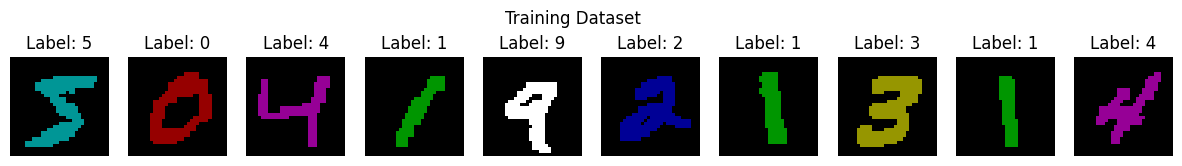

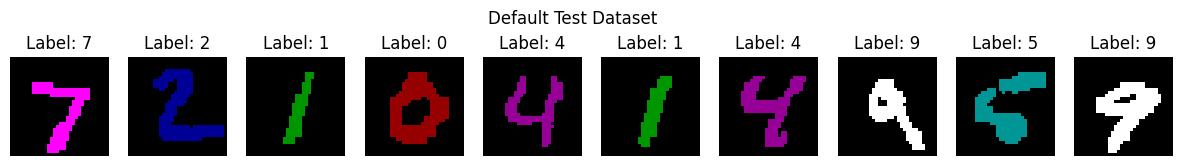

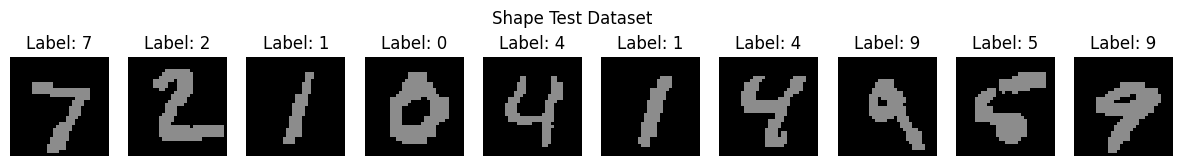

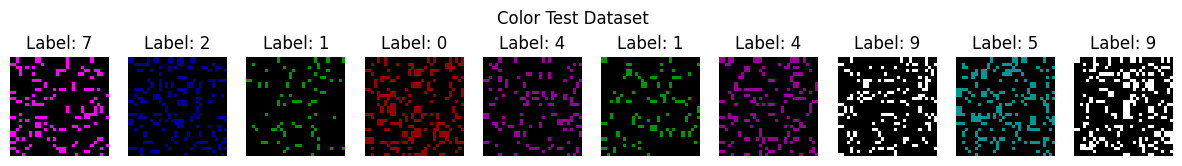

In [2]:
import numpy as np
from PIL import Image
import random
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from dataset import *


train_data = ColoredMNIST(train=True)
test_data_default = ColoredMNIST(train=False)
test_data_shape = ColoredMNIST(train=False, test_mode='shape')
test_data_color = ColoredMNIST(train=False, test_mode='color')

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loaders = {
    'default' :  DataLoader(test_data_default, batch_size=batch_size, shuffle=False),
    'shape' :  DataLoader(test_data_shape, batch_size=batch_size, shuffle=False),
    'color' :  DataLoader(test_data_color, batch_size=batch_size, shuffle=False),
}


visualize_dataset(train_data, title="Training Dataset")
visualize_dataset(test_data_default, title="Default Test Dataset")
visualize_dataset(test_data_shape, title="Shape Test Dataset")
visualize_dataset(test_data_color, title="Color Test Dataset")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from timm.models.layers import to_2tuple
from tqdm import tqdm

class DINOv2Classifier(nn.Module):
    def __init__(self, img_size=32, patch_size=7, num_classes=10):
        super(DINOv2Classifier, self).__init__()
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14', pretrained=True)
        self.dino.patch_embed.img_size = to_2tuple(img_size)
        self.dino.patch_embed.patch_size = to_2tuple(patch_size)
        self.dino.head = nn.Linear(self.dino.embed_dim, num_classes)

    def forward(self, x):
        return self.dino(x)


def train_model(model, train_loader, test_loaders, criterion, optimizer, device, epochs=5):
    train_metrics = []
    test_metrics = {name: [] for name in test_loaders}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        train_metrics.append({'loss': epoch_loss, 'accuracy': train_accuracy})

        test_accuracies = evaluate_model(model, test_loaders, device)
        for name, acc in test_accuracies.items():
            test_metrics[name].append(acc)

        print(f"Epoch {epoch + 1}: Train Loss = {epoch_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%")
        for name, acc in test_accuracies.items():
            print(f"  {name} Test Accuracy = {acc:.2f}%")

    print("Training complete.")
    return train_metrics, test_metrics

def evaluate_model(model, data_loaders, device):
    accuracy_dict = {}
    model.eval()

    with torch.no_grad():
        for name, data_loader in data_loaders.items():
            correct = 0
            total = 0

            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)

                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            accuracy = 100. * correct / total
            accuracy_dict[name] = accuracy

    return accuracy_dict


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = DINOv2Classifier(img_size=32, patch_size=4, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_metrics, test_metrics = train_model(model, train_loader, test_loaders, criterion, optimizer, device, epochs=10)


c:\Users\sever\OneDrive\Рабочий стол\SSL project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sever\OneDrive\Рабочий стол\SSL project\.venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda


Using cache found in C:\Users\sever/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\sever/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\sever/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\sever/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Epoch 1/10: 100%|██████████| 938/938 [00:25<00:00, 36.11it/s]


Epoch 1: Train Loss = 0.0434, Train Accuracy = 98.89%
  default Test Accuracy = 99.83%
  shape Test Accuracy = 26.21%
  color Test Accuracy = 88.90%


Epoch 2/10: 100%|██████████| 938/938 [00:24<00:00, 37.85it/s]


Epoch 2: Train Loss = 0.0046, Train Accuracy = 99.88%
  default Test Accuracy = 99.87%
  shape Test Accuracy = 16.72%
  color Test Accuracy = 87.11%


Epoch 3/10: 100%|██████████| 938/938 [00:24<00:00, 37.95it/s]


Epoch 3: Train Loss = 0.0111, Train Accuracy = 99.71%
  default Test Accuracy = 99.92%
  shape Test Accuracy = 16.02%
  color Test Accuracy = 89.71%


Epoch 4/10: 100%|██████████| 938/938 [00:24<00:00, 37.88it/s]


Epoch 4: Train Loss = 0.0050, Train Accuracy = 99.87%
  default Test Accuracy = 99.96%
  shape Test Accuracy = 18.53%
  color Test Accuracy = 90.34%


Epoch 5/10: 100%|██████████| 938/938 [00:25<00:00, 36.42it/s]


Epoch 5: Train Loss = 0.0071, Train Accuracy = 99.79%
  default Test Accuracy = 99.76%
  shape Test Accuracy = 18.65%
  color Test Accuracy = 83.82%


Epoch 6/10: 100%|██████████| 938/938 [00:25<00:00, 36.61it/s]


Epoch 6: Train Loss = 0.0062, Train Accuracy = 99.82%
  default Test Accuracy = 99.91%
  shape Test Accuracy = 14.39%
  color Test Accuracy = 86.77%


Epoch 7/10: 100%|██████████| 938/938 [00:25<00:00, 36.25it/s]


Epoch 7: Train Loss = 0.0019, Train Accuracy = 99.95%
  default Test Accuracy = 99.92%
  shape Test Accuracy = 22.81%
  color Test Accuracy = 80.35%


Epoch 8/10: 100%|██████████| 938/938 [00:25<00:00, 36.56it/s]


Epoch 8: Train Loss = 0.0021, Train Accuracy = 99.95%
  default Test Accuracy = 99.89%
  shape Test Accuracy = 22.93%
  color Test Accuracy = 81.76%


Epoch 9/10: 100%|██████████| 938/938 [00:25<00:00, 36.75it/s]


Epoch 9: Train Loss = 0.0104, Train Accuracy = 99.74%
  default Test Accuracy = 99.95%
  shape Test Accuracy = 12.26%
  color Test Accuracy = 81.49%


Epoch 10/10: 100%|██████████| 938/938 [00:24<00:00, 38.12it/s]


Epoch 10: Train Loss = 0.0032, Train Accuracy = 99.92%
  default Test Accuracy = 99.92%
  shape Test Accuracy = 17.73%
  color Test Accuracy = 82.21%
Training complete.


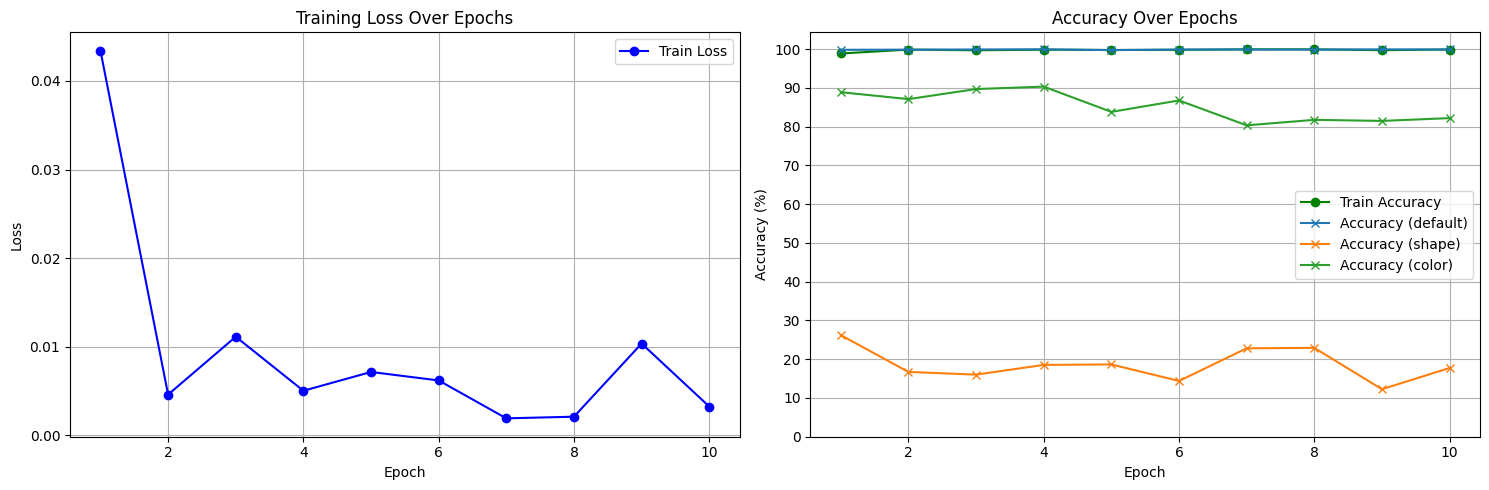

In [3]:
visualize_metrics(train_metrics, test_metrics, epochs=10)